# Construindo um Classificador de Textos
Uma das aplicações mais comuns em mineração de textos é a classificações de documentos em categorias pré-definidas, sejam elas autorais, temáticas, temporais ou outras. 

Neste capítulo iremos explorar os passos necessários para o desenvolvimento de um classificador de documentos utilizando as análises feitas sobre o corpus do DHBB nos capítulos anteriores.

Para esta tarefa utilizaremos modelos de machine learning clássicos disponibilizados na biblioteca [Scikit-Learn](https://scikit-learn.org/). Começaremos então importando algumas funcionalidades a partir do Scikit-Learn. Os demais imports já foram utilizados anteriormente.

In [1]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec, word2vec
import spacy
from spacy import displacy
from string import punctuation
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os

2022-11-16 12:51:06.863757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 12:51:07.453920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 12:51:08.804123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-16 12:51:08.804247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Preparando o corpus
Vamos utilizar o corpus do DHBB conforme armazenado na biblioteca SQLite anteriormente. Abaixo iremos desenvolver um iterador sobre o corpus que fará um preprocessamento básico dos documentos.

In [12]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
nlp = spacy.load("pt_core_news_sm")
class DHBBCorpus:
    def __init__(self, ndocs=10000, process=True):
        self.process = process
        self.ndocs = min(7687,ndocs)
        self.counter = 1
    def __iter__(self):
        with eng.connect() as con:
            res = con.execute(f'select corpo from resultados limit {self.ndocs};')
            for doc in res:
                if self.process:
                    d = self.pre_process(doc[0])
                else: 
                    d = doc[0]
                if self.counter%10 == 0:
                    print (f"Verbete {self.counter} de {self.ndocs}\r", end='')
                
                yield d
                self.counter += 1
    def pre_process(self, doc):
        n = nlp(doc, disable=['tagger', 'ner','entity-linker', 'textcat','entity-ruler','merge-noun-chunks','merge-entities','merge-subtokens'])
        results = [token.text.strip().strip(punctuation) for token in n if not token.is_stop]
        return results

## Carregando o Modelo Word2vec
Vamos utilizar a representação vetorial do corpus construida anteriormente como base para o treinamento do classificador. 

In [13]:
model = Word2Vec.load('dhbb.w2v')

In [14]:
model.wv.vectors.shape

(38762, 100)

Como  o word2vec é uma representação vetorial do vocabulário do corpus, e desejamos treinar um modelo para classificar documentos, precisamos primeiro construir uma representação dos documentos do corpus no mesmo espaço vetorial gerado pelo Word2vec.

Na função abaixo, contruimos um vetor de documento que é a média dos vetores das palavras únicas que este contém.

In [15]:
def build_document_vector(text):
    """
    Build a scaled vector for the document (mean of the words present in it)
    :param text: document to be vectorized (tokenized)
    :param model: word2vec model
    :return:
    """
    feature_count = model.wv.vectors.shape[1]
    vec = np.zeros(feature_count).reshape((1, feature_count))
    count = 0.
    

    for word in text:
        try:
            vec += model.wv[word].reshape((1, feature_count))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [16]:

def gera_docv(n):
    corpus = DHBBCorpus(n)
    for doc in corpus:
        v = build_document_vector(set(doc))
        yield v


## Preparando os dados treinamento do Classificador
Abaixo vamos calcular os vetores dos documentos no espaço definido pelo W2V. Como este é um processo longo vamos salvar o resultado, para não ter que re-gerar os vetores de documento das próximas vezes.

In [17]:
if os.path.exists('doc_feature_matrix.csv.gz')
    data = pd.read_csv('doc_feature_matrix.csv.gz')
else:
    gerador = gera_docv(10000)
    data = pd.DataFrame(data=np.vstack([a for a in gerador]), columns=range(100))
    data.to_csv('doc_feature_matrix.csv.gz')
data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.329596,-0.396530,-0.234968,-0.008919,-0.392844,0.082079,0.643818,-0.036871,-0.374934,0.124961,...,-0.081099,-0.177185,-0.233904,0.033541,0.796993,0.192985,0.214785,-0.679149,-0.522531,0.060596
1,-0.035577,-0.055027,-0.201358,0.587101,0.143018,0.238591,0.210333,-0.110109,-0.065921,0.119309,...,0.346693,0.047858,-0.110081,0.132066,0.261467,0.295954,0.172945,-0.311859,-0.530189,0.316330
2,0.197316,-0.189868,-0.271159,0.113843,-0.215909,0.009961,0.067409,-0.324156,-0.115856,-0.001585,...,-0.189233,0.419339,-0.113524,0.013359,0.213817,0.028746,-0.033972,-0.277325,0.123685,0.069090
3,0.014647,-0.066778,-0.286216,0.386036,-0.009316,0.152754,0.165088,-0.023266,-0.212305,0.176561,...,0.200119,0.120266,0.037666,0.046779,-0.003079,0.229816,0.004536,-0.170485,-0.298309,0.350582
4,0.090165,-0.315809,-0.481903,0.149809,-0.619123,-0.187226,0.241048,0.623205,-0.761205,0.581968,...,0.061845,-0.045994,-0.384362,-0.425419,1.413234,0.333866,0.776052,-0.494529,-1.045886,0.075690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7682,-0.090562,-0.084047,-0.383710,0.592161,-0.068067,0.279899,0.319775,-0.228383,-0.037196,-0.028221,...,0.274444,0.016063,-0.305153,0.150342,0.168861,0.206285,0.045919,-0.311792,-0.619057,0.102819
7683,0.287989,-0.194534,-0.632097,0.139947,-1.013919,-0.531953,0.278965,0.712771,-0.324023,0.646100,...,-0.502793,-0.146258,-0.535257,-0.699357,1.315595,0.183300,0.142800,-0.346391,-0.613722,-0.205855
7684,-0.294879,-0.429416,-0.505813,0.075155,-0.216774,0.174914,0.491742,0.038708,-0.140709,0.058136,...,-0.011171,-0.008312,-0.336977,-0.009365,0.171825,0.423463,0.004228,-0.400308,-0.435773,0.207956
7685,0.133161,-0.206598,-0.060065,0.013977,-0.309454,0.137658,0.484802,-0.104421,-0.151667,0.270099,...,-0.025340,-0.111797,-0.485028,-0.052700,0.432771,0.114540,0.181120,-0.433214,-0.202734,0.052010


In [18]:
data.to_csv('doc_feature_matrix.csv.gz')

### Definindo a categoria de cada documento para o treinamento

In [25]:
def gera_alvo():
    df = pd.read_sql_query('select natureza from resultados', con=eng)
    alvo = df.natureza.values=='biográfico'
    return alvo
Y = gera_alvo()
print(f"Número de verbetes não-biográficos: {len(Y)-sum(Y)}")

Número de verbetes não-biográficos: 963


In [26]:
df = pd.read_sql_query('select * from resultados', con=eng)

In [23]:
df.natureza.value_counts()

biográfico    6724
temático       963
Name: natureza, dtype: int64

Vamos dividir a tabela de vetores de documentos em Biográficos e temáticos

In [30]:
biog = data.iloc[Y]
tem = data.iloc[~Y]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.329596,-0.396530,-0.234968,-0.008919,-0.392844,0.082079,0.643818,-0.036871,-0.374934,0.124961,...,-0.081099,-0.177185,-0.233904,0.033541,0.796993,0.192985,0.214785,-0.679149,-0.522531,0.060596
1,-0.035577,-0.055027,-0.201358,0.587101,0.143018,0.238591,0.210333,-0.110109,-0.065921,0.119309,...,0.346693,0.047858,-0.110081,0.132066,0.261467,0.295954,0.172945,-0.311859,-0.530189,0.316330
2,0.197316,-0.189868,-0.271159,0.113843,-0.215909,0.009961,0.067409,-0.324156,-0.115856,-0.001585,...,-0.189233,0.419339,-0.113524,0.013359,0.213817,0.028746,-0.033972,-0.277325,0.123685,0.069090
3,0.014647,-0.066778,-0.286216,0.386036,-0.009316,0.152754,0.165088,-0.023266,-0.212305,0.176561,...,0.200119,0.120266,0.037666,0.046779,-0.003079,0.229816,0.004536,-0.170485,-0.298309,0.350582
4,0.090165,-0.315809,-0.481903,0.149809,-0.619123,-0.187226,0.241048,0.623205,-0.761205,0.581968,...,0.061845,-0.045994,-0.384362,-0.425419,1.413234,0.333866,0.776052,-0.494529,-1.045886,0.075690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7682,-0.090562,-0.084047,-0.383710,0.592161,-0.068067,0.279899,0.319775,-0.228383,-0.037196,-0.028221,...,0.274444,0.016063,-0.305153,0.150342,0.168861,0.206285,0.045919,-0.311792,-0.619057,0.102819
7683,0.287989,-0.194534,-0.632097,0.139947,-1.013919,-0.531953,0.278965,0.712771,-0.324023,0.646100,...,-0.502793,-0.146258,-0.535257,-0.699357,1.315595,0.183300,0.142800,-0.346391,-0.613722,-0.205855
7684,-0.294879,-0.429416,-0.505813,0.075155,-0.216774,0.174914,0.491742,0.038708,-0.140709,0.058136,...,-0.011171,-0.008312,-0.336977,-0.009365,0.171825,0.423463,0.004228,-0.400308,-0.435773,0.207956
7685,0.133161,-0.206598,-0.060065,0.013977,-0.309454,0.137658,0.484802,-0.104421,-0.151667,0.270099,...,-0.025340,-0.111797,-0.485028,-0.052700,0.432771,0.114540,0.181120,-0.433214,-0.202734,0.052010


In [32]:
data2 = pd.concat([biog[:963],tem],axis=0)
Y2 = np.array([True]*963 + [False]*963)
# data2['Y2'] = Y2
# data2 = data2.sample(frac=1).reset_index(drop=True) #shuffle the
# Y2 = data2.pop('Y2')
# print(len(Y2))
data2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.329596,-0.396530,-0.234968,-0.008919,-0.392844,0.082079,0.643818,-0.036871,-0.374934,0.124961,...,-0.081099,-0.177185,-0.233904,0.033541,0.796993,0.192985,0.214785,-0.679149,-0.522531,0.060596
1,-0.035577,-0.055027,-0.201358,0.587101,0.143018,0.238591,0.210333,-0.110109,-0.065921,0.119309,...,0.346693,0.047858,-0.110081,0.132066,0.261467,0.295954,0.172945,-0.311859,-0.530189,0.316330
2,0.197316,-0.189868,-0.271159,0.113843,-0.215909,0.009961,0.067409,-0.324156,-0.115856,-0.001585,...,-0.189233,0.419339,-0.113524,0.013359,0.213817,0.028746,-0.033972,-0.277325,0.123685,0.069090
3,0.014647,-0.066778,-0.286216,0.386036,-0.009316,0.152754,0.165088,-0.023266,-0.212305,0.176561,...,0.200119,0.120266,0.037666,0.046779,-0.003079,0.229816,0.004536,-0.170485,-0.298309,0.350582
4,0.090165,-0.315809,-0.481903,0.149809,-0.619123,-0.187226,0.241048,0.623205,-0.761205,0.581968,...,0.061845,-0.045994,-0.384362,-0.425419,1.413234,0.333866,0.776052,-0.494529,-1.045886,0.075690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7575,0.020225,-0.280477,-0.170159,0.351982,-0.280089,0.274388,0.172454,-0.080712,0.093399,0.208950,...,-0.066207,0.362904,-0.068540,0.065754,-0.356943,-0.072042,-0.204973,-0.224963,0.124520,0.098407
7576,0.077916,0.119692,-0.649958,0.349691,-0.335268,-0.338885,0.008561,-0.325136,-0.370986,0.445588,...,-0.451669,0.087047,-0.432664,-0.288538,0.468374,-0.238418,0.096321,-0.139604,-0.089983,0.046872
7577,0.182282,0.466217,-0.756201,0.422557,-0.447586,-0.619644,-0.250793,-0.030172,-0.086136,0.670983,...,-0.555409,0.112438,-0.558620,-0.638075,0.664470,-0.062651,-0.122452,-0.151964,-0.189627,0.053312
7578,0.068453,-0.240046,-0.733235,-0.081720,-0.593263,0.111453,0.494526,-0.083234,-0.416862,0.206093,...,-0.690739,0.503692,0.023055,-0.471232,0.524155,-0.095602,0.051709,-0.186506,0.080684,0.077073


In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
def print_class_report(Xtest, Ytest, clf, clf_name):
    """
    Prints Classification report
    :param Xtest:
    :param Ytest:
    :param clf: trained classifier
    :param clf_name: Name for the classifier
    """
    y_predict = clf.predict(Xtest)
    print('\nClassification Report for {}:\n'.format(clf_name))
    print(classification_report(Ytest, y_predict, target_names=['Temático', 'Biográfico']))
    

def plot_roc(probas):
    tprs = []
    fprs = []


    labels = ['False positive rate', 'True Positive rate']
    for k, v in probas.items():
        roc_aucs = []
        for j, fold in enumerate(v):
            try:
                fpr, tpr, thresholds = roc_curve(fold[1], fold[0][:, 1])
            except IndexError:
                print(fold[0], fold[0].shape)
                continue
            roc_aucs.append(auc(fpr, tpr))
            tprs.append([float(t) for t in tpr])
            fprs.append([float(f) for f in fpr])

        print('{}: AUCs: {}'.format(k, str(roc_aucs)))
    plt.scatter(fprs, tprs, [], "ROC curve", "points", 0, 0)
    

## Definindo os modelos

In [34]:
rfclf = RandomForestClassifier(n_estimators=400, criterion='entropy', n_jobs=-1, min_samples_leaf=3, warm_start=True, verbose=0)
etclf = ExtraTreesClassifier(n_estimators=400, n_jobs=-1,min_samples_leaf=3, warm_start=True, verbose=0)

In [35]:
vcclf = VotingClassifier(estimators=[('rf', rfclf), ('et', etclf)], voting='soft', weights=[1,1])

## Treinando e validando o classificador

==> Fitting:
==> Extra Trees
Random Forest
Voting
==> Scoring:
==> Fitting:
==> Extra Trees
Random Forest
Voting


/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


==> Scoring:
==> Fitting:
==> Extra Trees
Random Forest
Voting


/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/home/fccoelho/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


==> Scoring:

Classification Report for ET:

              precision    recall  f1-score   support

    Temático       1.00      0.02      0.04       262
  Biográfico       0.46      1.00      0.63       220

    accuracy                           0.47       482
   macro avg       0.73      0.51      0.34       482
weighted avg       0.75      0.47      0.31       482


Classification Report for RF:

              precision    recall  f1-score   support

    Temático       1.00      0.22      0.36       262
  Biográfico       0.52      1.00      0.68       220

    accuracy                           0.57       482
   macro avg       0.76      0.61      0.52       482
weighted avg       0.78      0.57      0.51       482


Classification Report for Voting:

              precision    recall  f1-score   support

    Temático       1.00      0.08      0.15       262
  Biográfico       0.48      1.00      0.65       220

    accuracy                           0.50       482
   macro avg   

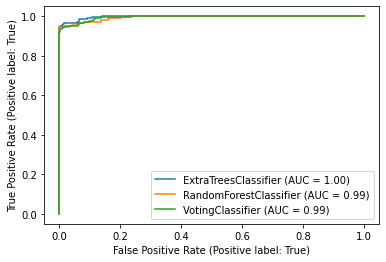

In [37]:
from collections import defaultdict
from sklearn.metrics import RocCurveDisplay

scaler = StandardScaler()

acc_hist = defaultdict(lambda: [])
X2 = data2.values

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X2,Y2, test_size=.25)

probas = defaultdict(lambda: [])
skf = StratifiedKFold(3, shuffle=True)

for train_index, test_index in skf.split(Xtrain, Ytrain):
    scaler.fit(Xtrain)
    Xtr = scaler.transform(Xtrain[train_index])
    Ytr = Ytrain[train_index]
    Xval = Xtrain[test_index]
    Yval = Ytrain[test_index]
    print("==> Fitting:")
    print("==> Extra Trees")
    etclf.fit(Xtr,Ytrain[train_index])
    print("Random Forest")
    rfclf.fit(Xtr, Ytrain[train_index])
    probas['RF'].append((rfclf.predict_proba(Xval), Yval))
    print("Voting")
    vcclf.fit(Xtr, Ytrain[train_index])
    probas['Voting'].append(vcclf.predict_proba(Xval))
    print("==> Scoring:")
    acc_hist['ET'].append(cross_val_score(etclf, Xtrain, Ytrain, cv=2, n_jobs=-1).mean())

    acc_hist['RF'].append(cross_val_score(rfclf, Xtrain, Ytrain, cv=2, n_jobs=-1).mean())
    acc_hist['Voting'].append(vcclf.score(Xtrain, Ytrain))
print_class_report(Xtest, Ytest, etclf, 'ET')
print_class_report(Xtest, Ytest, rfclf, 'RF')
print_class_report(Xtest, Ytest, vcclf, 'Voting')

#  ROC curve for each model

et_roc = RocCurveDisplay.from_estimator(etclf, Xtest, Ytest)
ax = plt.gca()
rf_roc = RocCurveDisplay.from_estimator(rfclf, Xtest, Ytest, ax=ax)
vc_roc = RocCurveDisplay.from_estimator(vcclf, Xtest, Ytest, ax=ax)

# print('trained {} documents.'.format((n+1)*batchsize))
df_acc = pd.DataFrame(acc_hist)

In [38]:
from sklearn.metrics import PrecisionRecallDisplay

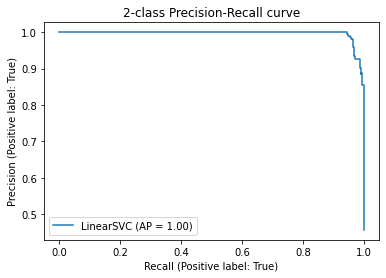

In [39]:
display = PrecisionRecallDisplay.from_estimator(
    etclf, Xtest, Ytest, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Testing with a different feature matrix

In [40]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

NameError: name 'categories' is not defined

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words=[])
corpus = DHBBCorpus(process=False)
X_train_counts = tfidf_vect.fit_transform(corpus)
X_train_counts.shape

(7687, 28964)

In [47]:
X_train_counts

<7687x28964 sparse matrix of type '<class 'numpy.float64'>'
	with 2838315 stored elements in Compressed Sparse Row format>